In [1]:
from pygeoinf.interval.lebesgue_space import Lebesgue
from pygeoinf.interval.sobolev_space import Sobolev
from pygeoinf.interval.operators import Laplacian
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.functions import Function
import numpy as np
from matplotlib import pyplot as plt

In [2]:
function_domain = IntervalDomain(0.0, 1.0)
l2_space_dim = 10
l2_basis = None
l2space = Lebesgue(l2_space_dim, function_domain, basis=l2_basis)

bcs = BoundaryConditions('dirichlet', left=0.0, right=0.0)
method = 'finite_difference'
laplacian_fd_dofs = 100
laplacian_fd_order = 2
laplacian = Laplacian(l2space, bcs, method=method,
                      dofs=laplacian_fd_dofs,
                      fd_order=laplacian_fd_order)

mass_op = l2space.identity_operator() + laplacian

<Axes: title={'center': 'Function on [0.0, 1.0]'}, xlabel='x', ylabel='f(x)'>

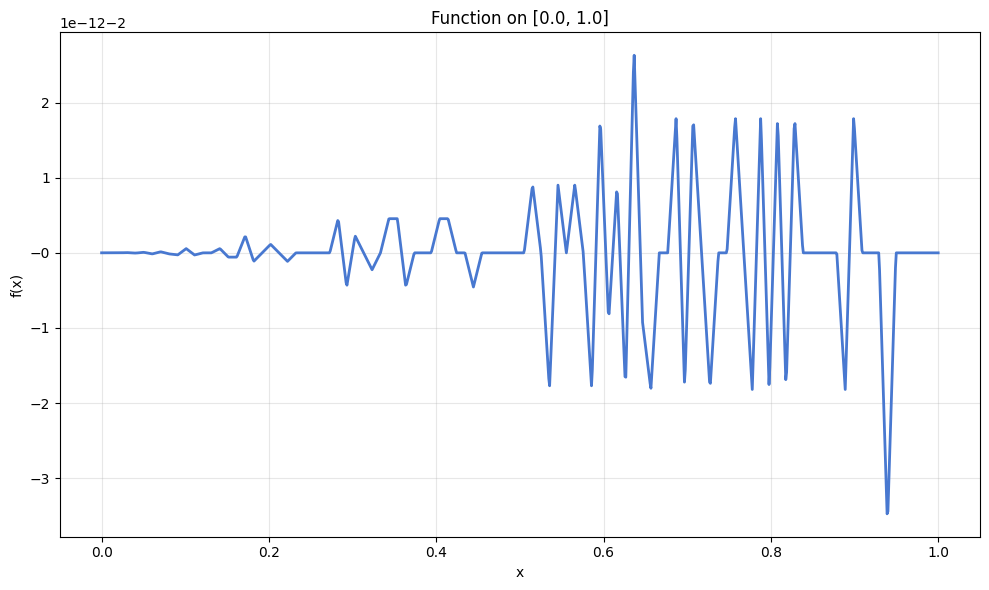

In [3]:
f = Function(l2space, evaluate_callable=lambda x: x**2)
g = laplacian(f)
g.plot()

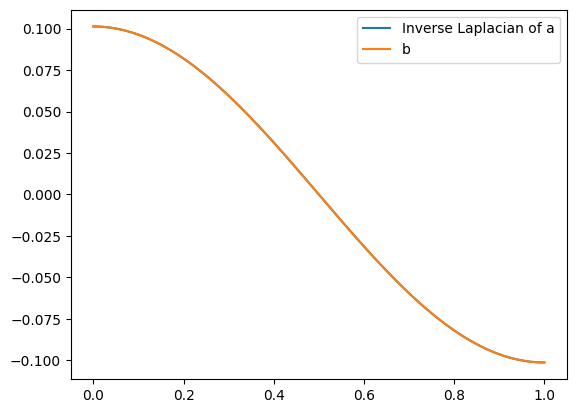

In [ ]:
from pygeoinf.interval.operators import InverseLaplacian
bcs = BoundaryConditions('periodic', left=0.0, right=0.0)
inv_lap = InverseLaplacian(l2space, bcs, dofs=100)
x = function_domain.uniform_mesh(100)
a = Function(l2space, evaluate_callable=lambda x: np.cos(np.pi * x))
b = Function(l2space, evaluate_callable=lambda x: np.cos(np.pi * x) / (np.pi**2))

plt.plot(x, inv_lap(a)(x), label='Inverse Laplacian of a')
plt.plot(x, b(x), label='b')
plt.legend()